# ALPHA DIVERSITY PREDICTION

This Jupyter Notebook contains main functions to run a dynamic ARIAMX model with Fourier seasonality component


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import SimpleExpSmoothing

from scipy import stats
from scipy import fft
from scipy import signal as sig
from scipy.fft import fft, fftfreq, ifft, rfft, rfftfreq
from cmath import phase
import math

In [4]:
wd =  './data/alpha_diversity/shannon/'

In [5]:
male_data = pd.read_csv(wd + 'male_shannon_entropy.csv')
female_data = pd.read_csv(wd + 'female_shannon_entropy.csv')
donorA_data = pd.read_csv(wd + 'donorA_shannon_entropy.csv')
donorB_data = pd.read_csv(wd + 'donorB_shannon_entropy.csv')#.iloc[:150]

### I. Predict alpha diversity change in time using a dynamic ARIMA model with Fourier seasonality variable

In [6]:
def smooth_data(X, smoothing_level=.7):
    
    ''' 
    smooth input data with SimpleExpSmoothing
    '''
    
    model = SimpleExpSmoothing(np.asarray(X), initialization_method = 'estimated')
    fit = model.fit(smoothing_level=smoothing_level)
    pred = fit.predict(1, X.shape[0])
    return pred

def detrend_ts(ts):
    
    '''
    remove trend from variable by first fitting a linear regression model to the data 
    to estimate trend and, removing it from the variable
    '''
    
    X = np.arange(0, len(ts))
    X = X.reshape(len(X), 1)
    y = ts
    model = LinearRegression()
    model.fit(X, y) 

    prediction = model.predict(X)
    residuals = y - prediction
    
    return residuals

def fft_decomposition(signal):
    
    ''' 
    analyse sesonal component in data
    '''
    
    signal = detrend_ts(signal)
    fft_output = fft(signal)
    amplitude = np.abs(fft_output)
    freq = fftfreq(len(signal), 1)

    mask = freq >= 0
    freq = freq[mask]
    amplitude = amplitude[mask]

    peaks = sig.find_peaks(amplitude[freq >=0].reshape(len(amplitude),))[0]
    peak_freq =  freq[peaks]
    peak_amplitude = amplitude[peaks]
    
    # create dataframe with results from FFT
    output = pd.DataFrame()
    output['index'] = peaks
    output['fft'] = fft_output[peaks]
    output['freq (1/day)'] = peak_freq
    output['period [days]'] = 1/output['freq (1/day)']
    output['phase'] = output.fft.apply(lambda z: phase(z))
    output['amplitude'] = peak_amplitude

    return output
    
def create_fourier_dict(fft_output, data, n_modes):
    
    output = fft_output[(fft_output['period [days]'] < len(data)//2)]        
    output = output.sort_values('amplitude', ascending=False)
    output['label'] = list(map(lambda n : 'FT_{}'.format(n), range(1, len(output) + 1)))
    
    # get n modes
    output = output.head(n_modes)
    output = output.set_index('label')
    fourier_terms_dict = output.to_dict('index')
    
    return fourier_terms_dict
    
def create_fourier_df(fourier_terms_dict, size):
    
    '''
    create a seasonal wave with n Fourier dominant modes
    '''
    
    data = pd.DataFrame(np.arange(0, size), columns = ['time'])
    
    for key in fourier_terms_dict.keys():
        a = fourier_terms_dict[key]['amplitude']
        w = 2 * math.pi * (fourier_terms_dict[key]['freq (1/day)'])
        p = fourier_terms_dict[key]['phase']
        data[key] = data['time'].apply(lambda t: a * math.cos(w*t + p))

    data['FT_All'] = 0
    for column in list(fourier_terms_dict.keys()):
        data['FT_All'] = data['FT_All'] + data[column]
    
    return  data

def arimax_model(train, n_modes, p, q, train_fold_size, test_fold_size, trend = False):
    
    f1 = fft_decomposition(train)
    f2 = create_fourier_dict(f1, n_modes)
  
    exog_train = create_fourier_df(f2, train_fold_size)
    exog_test = create_fourier_df(f2, test_fold_size)
    
    if trend == False:

        arima_model = ARIMA((train), order = (p, 0, q), exog=exog_train[['FT_All']])
        arima_model_fit = arima_model.fit(method_kwargs={"warn_convergence": False})

        prediction = arima_model_fit.predict(start=train_fold_size, end=((train_fold_size+test_fold_size)-1),
                                             exog=exog_test[['FT_All']], dynamic=True)
        
    elif trend == True:
        arima_model = ARIMA((train), order = (p, 0, q), exog=exog_train[['time', 'FT_All']])
        arima_model_fit = arima_model.fit(method_kwargs={"warn_convergence": False})

        prediction = arima_model_fit.predict(start=train_fold_size, end=((train_fold_size+test_fold_size)-1),
                                             exog=exog_test[['time','FT_All']], dynamic=True)
    
    return prediction, f2

In [10]:
def dynamic_model_predict(df, **model_param_dict):
    
    data = df.astype(float)
    
    n_modes = model_param_dict['n_modes']
    p = model_param_dict['p']
    d = model_param_dict['d']
    q = model_param_dict['q']
    


    #split into train and test
    train = data[:80]
    test = data[80:]
    train_fold_size = len(train)
    test_fold_size = len(test)

    #smooth data
    train_smoothed = smooth_data(train)
    test_smoothed = smooth_data(test)

    #create Fourier seasonal wave 
    seasonal_decomposition_res = fft_decomposition(train_smoothed)
    seasonal_variable = create_fourier_dict(seasonal_decomposition_res, train_smoothed, n_modes)
    exog_train = create_fourier_df(seasonal_variable, len(train_smoothed))
    exog_test = create_fourier_df(seasonal_variable, len(test_smoothed))

    #smooth y true
    y_true_smoothed = smooth_data(data.iloc[1:])

    # fit ARIMA model
    arima_model = ARIMA((train_smoothed), order = (p, d, q), exog=(exog_train['FT_All']))
    arima_model_fit = arima_model.fit(method_kwargs={"warn_convergence": False})
    prediction = arima_model_fit.predict(start=0, end=(len(data)-1), exog=(exog_test['FT_All']), dynamic=True)

    return y_true_smoothed, prediction

In [12]:
def plot_prediction(y_true, y_pred, subject):

    plt.figure(figsize = (12, 4))
    plt.plot(y_true, linestyle='-.', color='k', lw=1, label='ytrue')
    plt.plot(y_true, 'o', color='k', markersize=4)

    plt.plot(y_pred.values, color='#EA1313', lw=1.2, label='ypred', linestyle = '-')
    plt.plot(y_pred.values, 'o', color='#EA1313', markersize=4)

    plt.legend(fancybox=True, ncol=2, edgecolor='k', fontsize=12)

    plt.xlabel('time point [days]', fontsize=14)
    plt.ylabel('Shannon diversity Index', fontsize=14)

    plt.grid(axis='y', linestyle = ':', color='lightgrey')

    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=12)

    if subject == 'female':
        plt.xlim([0, 130])
    else:
        plt.xlim([0, 200])
    plt.ylim([y_true.min()-0.05, y_true.max()+0.05])

    plt.fill_between(x = np.arange(80), y1 = y_true.min(), y2=y_true.max(), color='lightgrey', alpha=0.3)
    plt.fill_between(x = np.arange(80, len(y_true)), y1 = y_true.min(), y2=y_true.max(), color='#ffca3a', alpha=0.2)

    if subject == 'donorA':
        plt.fill_between(y_pred.index.values[100:122], y1=y_true.min()-0.1, y2=y_true.max()+0.05, alpha=.1, color='red')
    elif subject == 'donorB':
        plt.fill_between(y_pred.index.values[150:159], y1=y_true.min()-0.1, y2=y_true.max()+0.05, alpha=.1, color='red')
    else:
        pass
    
    plt.axvline(80, color='k', linestyle = '-.', lw=2)
    
    plt.tight_layout()
    plt.show()

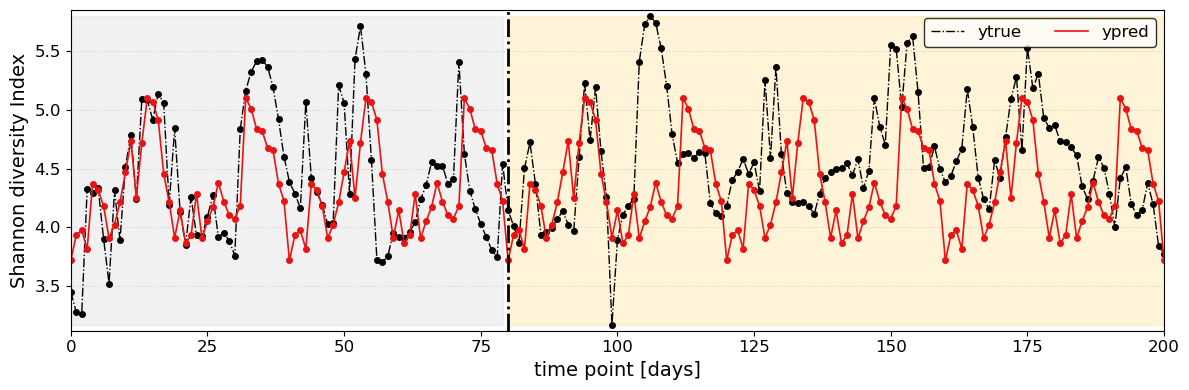

In [13]:
male_param_dict = {'n_modes':6,
                         'p':3, 
                         'd':0,
                         'q':10}

male_y_true, male_y_pred = dynamic_model_predict(male_data, **male_param_dict)
plot_prediction(male_y_true, male_y_pred, 'male')

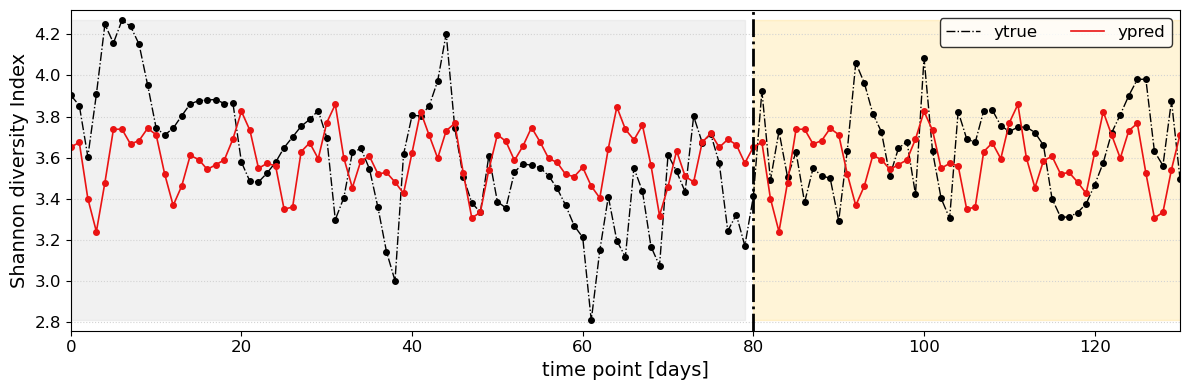

In [14]:
female_param_dict = {'n_modes':6,
                         'p':2, 
                         'd':0,
                         'q':7}
new_index = female_data.iloc[50:].index
data = female_data.iloc[50:].reset_index(drop=True).astype(float)

female_y_true, female_y_pred = dynamic_model_predict(data, **female_param_dict)
plot_prediction(female_y_true, female_y_pred, 'female')

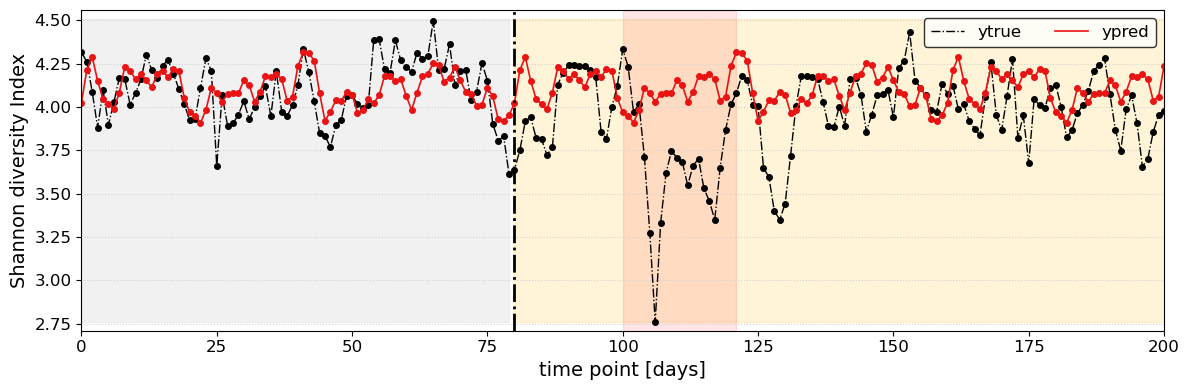

In [15]:
donorA_param_dict = {'n_modes':6,
                         'p':3, 
                         'd':0,
                         'q':1}

donorA_y_true, donorA_y_pred = dynamic_model_predict(donorA_data, **donorA_param_dict)
plot_prediction(donorA_y_true, donorA_y_pred, 'donorA')

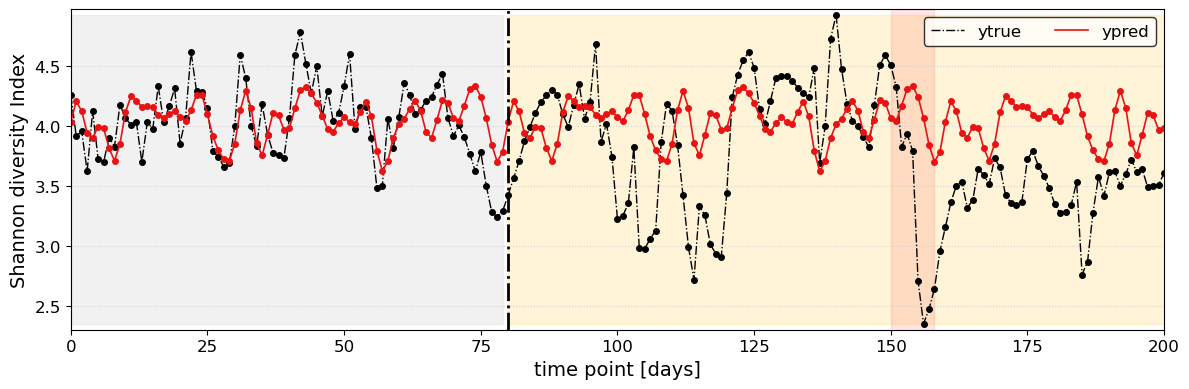

In [16]:
donorB_param_dict = {'n_modes':6,
                         'p':4, 
                         'd':0,
                         'q':7}

donorB_y_true, donorB_y_pred = dynamic_model_predict(donorB_data, **donorB_param_dict)
plot_prediction(donorB_y_true, donorB_y_pred, 'donorB')

### III. Visualize dominant modes (train set)

/home/MCB/zkarwowska/anaconda3/envs/time_series_env/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:1201: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
/home/MCB/zkarwowska/anaconda3/envs/time_series_env/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:1201: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
/home/MCB/zkarwowska/anaconda3/envs/time_series_env/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:1201: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
/home/MCB/zkarwowska/anaconda3/envs/time_series_env/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:1201: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


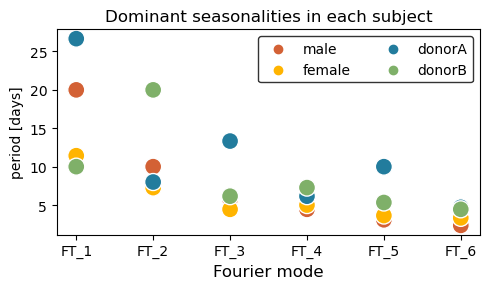

In [17]:
def get_periods(data, n, subject):
    
    '''
    get periods of used seasonalities
    '''
    
    train_smoothed = smooth_data(data, 0.5)
    f1 = fft_decomposition(train_smoothed)
    period= create_fourier_dict(f1, train_smoothed, n)
    periods_df = pd.DataFrame.from_dict(period).T['period [days]'].astype(float).reset_index()
    periods_df['subject'] = subject

    return periods_df


cmap = {'male':'#d36135', 
        'female':'#ffb400' ,
        'donorA':'#227c9d', 
        'donorB':'#7fb069'}

periods = pd.concat([get_periods(male_data.iloc[:80], 6, 'male'),
          get_periods(female_data.iloc[50:130], 6, 'female'),
          get_periods(donorA_data.iloc[:80], 6, 'donorA'),
          get_periods(donorB_data.iloc[:80], 6, 'donorB')])

plt.figure(figsize = (5, 3))
sns.scatterplot(data=periods, x = 'index', y = 'period [days]', hue = 'subject', legend=True, s=150, palette=cmap)
plt.legend(fancybox=True, ncol=2, edgecolor='k')
plt.xlabel('Fourier mode', fontsize=12)
plt.title('Dominant seasonalities in each subject', fontsize=12)
plt.tight_layout()

### III. Score prediction on the test set

In [18]:
def get_prediction_scores(y_true, y_pred, subject):
    
    results = []   
    for n in range(0, len(y_pred)-20, 3):
        try:
        
            ytrue = y_true[n: (20+n)]
            ypred = y_pred[n: (20+n)]

            emd = np.round(stats.wasserstein_distance(ytrue, ypred), 2)
            mape = np.round(mean_absolute_percentage_error(ytrue, ypred), 2)
            
            results.append({'emd':emd,
                            'mape':mape})
        except: pass

    results_df = pd.DataFrame.from_dict(results)
    results_df['subject'] = subject
    
    return results_df


#get test sets

male_score = get_prediction_scores(male_y_true[80:], male_y_pred[80:], 'male')
female_score = get_prediction_scores(female_y_true[80:], female_y_pred[80:], 'female')
donorA_score = get_prediction_scores(donorA_y_true[80:], donorA_y_pred[80:], 'donorA')
donorB_score = get_prediction_scores(donorB_y_true[80:], donorB_y_pred[80:], 'donorB')

scores = pd.concat([male_score, female_score, donorA_score, donorB_score])

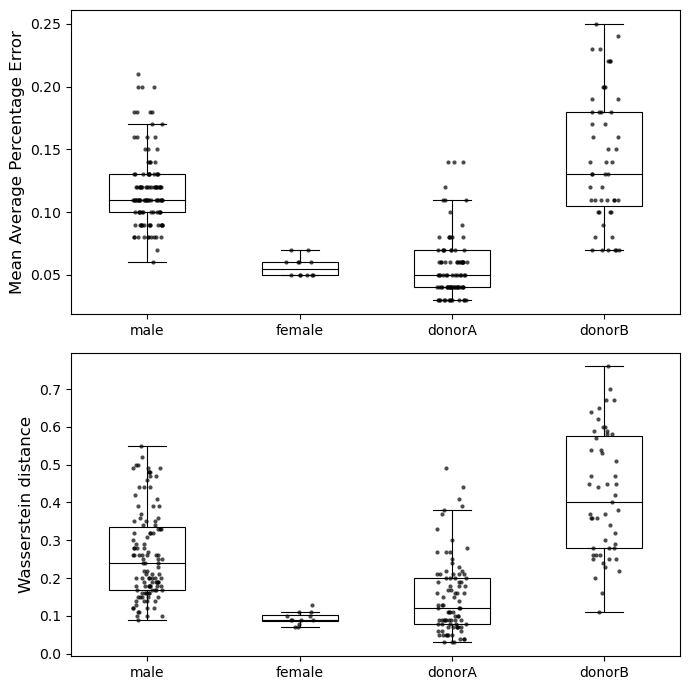

In [20]:
fig, axes = plt.subplots(2, 1, figsize = (7, 7))

c = 'k'
sns.boxplot(data=scores, 
            x = 'subject', 
            y = 'mape', 
            ax= axes[0], 
            color = 'white',
            fliersize=0, 
            linewidth=.8, 
            width=.5,  
            boxprops=dict(facecolor='white', color='w', edgecolor= 'k'),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            medianprops=dict(color=c))   

sns.stripplot(data=scores, 
              x = 'subject',
              y = 'mape', 
              ax= axes[0], 
              alpha=.7, 
              s=3, 
              color='k')

sns.boxplot(data=scores, 
            x = 'subject', 
            y = 'emd', 
            ax= axes[1], 
            color = 'white', 
            fliersize=0, 
            linewidth=.8, 
            width=.5,
            boxprops=dict(facecolor='white', color='w', edgecolor= 'k'),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            medianprops=dict(color=c))

sns.stripplot(data=scores, 
              x = 'subject',
              y = 'emd',
              ax= axes[1],
              alpha=.7,
              s=3, 
              color='k')

axes[0].set_xlabel('')
axes[0].set_ylabel('Mean Average Percentage Error', fontsize=12)

axes[1].set_xlabel('')
axes[1].set_ylabel('Wasserstein distance', fontsize=12)

plt.tight_layout()